# Préparation des données

Montage google drive et décompression des données de bdappv.zip

In [1]:
import sys
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
#sys.path.insert(0,'/content/drive/My Drive/statapps-main/src/')
!unzip /content/drive/MyDrive/bdappv/bdappv.zip > /dev/null

Mounted at /content/drive/


Importation du fichier dataloader pour pouvoir utiliser ses modules

In [2]:
!cp /content/drive/MyDrive/statapps-main/src/dataloader.py /content

In [26]:
import dataloader as dtld

In [27]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from PIL import Image
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [28]:
label_attribution = dtld.LabelAttribution(path_image_google='/content/bdappv/google/img', 
                                   path_mask_google='/content/bdappv/google/mask',
                                   path_metadata='/content/bdappv/metadata.csv',
                                   colonne_identifiant='identifiant',
                                   path_export_train_test='/content/drive/MyDrive',
                                   path_image_ign='/content/bdappv/ign/img',
                                   path_mask_ign='/content/bdappv/ign/mask',
                                   use_img_google=True,
                                   use_img_ign=False
                                    )

In [29]:
label_attribution.run()

In [30]:
path_train='/content/drive/MyDrive/train_data.csv'
path_test='/content/drive/MyDrive/test_data.csv'

transformed_train_dataset  = dtld.CustomImageDataset(path_train,'/content/bdappv/google/img', transform=transforms.Compose([
                                               transforms.Resize(224),
                                               transforms.ToTensor()
                                           ]))
transformed_test_dataset = dtld.CustomImageDataset(path_test,"/content/bdappv/google/img",
                                                transform=transforms.Compose([
                                               transforms.Resize(224),
                                               transforms.ToTensor(),
                                           ]))

In [31]:
print("Nombre d'images dans le train: {}".format(transformed_train_dataset.__len__()))
print("Nombre d'images dans le test: {}".format(transformed_test_dataset.__len__()))

Nombre d'images dans le train: 23045
Nombre d'images dans le test: 5762


In [32]:
train_dataloader = DataLoader(transformed_train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(transformed_test_dataset, batch_size=16, shuffle=True)

## Normalisation des données par batch

In [33]:
mean_train, std_train = dtld.batch_mean_and_sd(train_dataloader)
print("Moyenne par channel: {}".format(mean_train.tolist()))
print("Ecart-type par channel: {}".format(std_train.tolist()))


mean_test, std_test = dtld.batch_mean_and_sd(test_dataloader)
print("Moyenne par channel: {}".format(mean_test.tolist()))
print("Ecart-type par channel: {}".format(std_test.tolist()))

Moyenne par channel: [0.3492797613143921, 0.3566456139087677, 0.30715712904930115]
Ecart-type par channel: [0.20040494203567505, 0.18340453505516052, 0.1782950758934021]
Moyenne par channel: [0.349591463804245, 0.357334166765213, 0.30777692794799805]
Ecart-type par channel: [0.20135053992271423, 0.18425364792346954, 0.17945747077465057]


In [34]:
normalized_train_dataset  = dtld.CustomImageDataset(path_train,'/content/bdappv/google/img', transform=transforms.Compose([
                                               transforms.Resize(224),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean = mean_train.tolist(),
                                                                    std= std_train.tolist()),
                                               transforms.RandomHorizontalFlip(),
                                           ]))

normalized_test_dataset  = dtld.CustomImageDataset(path_test,"/content/bdappv/google/img", transform=transforms.Compose([
                                               transforms.Resize(224),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean = mean_test.tolist(),
                                                                    std= std_test.tolist()),
                                               transforms.RandomHorizontalFlip(),
                                           ]))

train_dataloader = DataLoader(normalized_train_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(normalized_test_dataset, batch_size=16, shuffle=False)

 # Implémentation ResNet18

In [35]:
from keras import layers
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import AveragePooling2D
from keras.layers import Flatten
from keras.layers import MaxPool2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.models import Model
from keras.regularizers import l2

In [36]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [37]:
def conv2d_bn(x, filters, kernel_size, weight_decay=.0, strides=(1, 1)):
    layer = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same',
                   use_bias=False,
                   kernel_regularizer=l2(weight_decay)
                   )(x)
    layer = BatchNormalization()(layer)
    return layer


def conv2d_bn_relu(x, filters, kernel_size, weight_decay=.0, strides=(1, 1)):
    layer = conv2d_bn(x, filters, kernel_size, weight_decay, strides)
    layer = Activation('relu')(layer)
    return layer


def ResidualBlock(x, filters, kernel_size, weight_decay, downsample=True):
    if downsample:
        # residual_x = conv2d_bn_relu(x, filters, kernel_size=1, strides=2)
        residual_x = conv2d_bn(x, filters, kernel_size=1, strides=2)
        stride = 2
    else:
        residual_x = x
        stride = 1
    residual = conv2d_bn_relu(x,
                              filters=filters,
                              kernel_size=kernel_size,
                              weight_decay=weight_decay,
                              strides=stride,
                              )
    residual = conv2d_bn(residual,
                         filters=filters,
                         kernel_size=kernel_size,
                         weight_decay=weight_decay,
                         strides=1,
                         )
    out = layers.add([residual_x, residual])
    out = Activation('relu')(out)
    return out


def ResNet18(classes, input_shape, weight_decay=1e-4):
    input = Input(shape=input_shape)
    x = input
    # x = conv2d_bn_relu(x, filters=64, kernel_size=(7, 7), weight_decay=weight_decay, strides=(2, 2))
    # x = MaxPool2D(pool_size=(3, 3), strides=(2, 2),  padding='same')(x)
    x = conv2d_bn_relu(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, strides=(1, 1))

    # # conv 2
    x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 3
    x = ResidualBlock(x, filters=128, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    x = ResidualBlock(x, filters=128, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 4
    x = ResidualBlock(x, filters=256, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    x = ResidualBlock(x, filters=256, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 5
    x = ResidualBlock(x, filters=512, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    x = ResidualBlock(x, filters=512, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    x = AveragePooling2D(pool_size=(4, 4), padding='valid')(x)
    x = Flatten()(x)
    x = Dense(classes, activation='softmax')(x)
    model = Model(input, x, name='ResNet18')
    return model

In [42]:
from keras import losses
from keras import optimizers

In [17]:
model = ResNet18(2, (224,224,3))
model.build(input_shape = (None,224 ,224 ,3))
from keras.optimizers import SGD
#opt = SGD(learning_rate=1*10**-4,momentum=0.9,decay = 1e-04) #parameters suggested by He [1]
model.compile(optimizer = 'sgd',loss='binary_crossentropy', metrics=["Accuracy",recall_m, precision_m, f1_m]) 
model.summary()

Model: "ResNet18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 224, 224, 64  1728        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_20 (BatchN  (None, 224, 224, 64  256        ['conv2d_20[0][0]']              
 ormalization)                  )                                                          

In [74]:
weight_decay = 1e-4
lr = 1e-4
resnet18 = ResNet18(input_shape=(224, 224, 3), classes= 2, weight_decay=weight_decay)
opt = optimizers.SGD(lr=lr, momentum=0.9, nesterov=False)
resnet18.compile(optimizer=opt,
                 loss=losses.binary_crossentropy,
                 metrics=['accuracy'])
resnet18.summary()

Model: "ResNet18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_220 (Conv2D)            (None, 224, 224, 64  1728        ['input_12[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_220 (Batch  (None, 224, 224, 64  256        ['conv2d_220[0][0]']             
 Normalization)                 )                                                          

In [70]:
X_train, Y_train=next(iter(train_dataloader))
X_test, Y_test=next(iter(test_dataloader))

In [71]:
X_train_permute=X_train.permute(0, 2, 3,1)
X_test_permute=X_test.permute(0, 2, 3,1)

In [ ]:
print(Y_test.numpy())
len(Y)

[0 0 1 1 0 1 0 0 1 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 0 0 1 1 0
 0 1 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0]


64

## On transforme le vecteur des labels pour qu'il correspondent au format attendu par le modèle

Un vecteur de 64 lignes (la dimension du batch) et deux colonnes (car on a deux labels possibles pour nos images).

In [72]:
def label_array_formatting(Y):
  formatted_Y = np.zeros((len(Y), 2))
  for i in range(len(Y)):
    if Y[i] == 1:
      formatted_Y[i][0], formatted_Y[i][1] = 0, 1
    else:
      formatted_Y[i][0], formatted_Y[i][1] = 1, 0
  return formatted_Y

## Lancement du modèle

On convertit le tenseur en array numpy pour que le modèle keras puisse le lire

In [73]:
model.fit(x = X_train_permute.numpy(), y = label_array_formatting(Y_train),
	validation_data=(X_test_permute.numpy(), label_array_formatting(Y_test)),
	batch_size=16,
	epochs=5)

Epoch 1/5


TypeError: ignored

# Lancement du modèle

Les cinq premières métriques représentent les performances de notre algorithme sur l'échantillon d'entrainement, les cinq dernières valeurs (celles précédées du préfixe val_) sont elles calculées sur l'échantillon de test. 

In [62]:
resnet18.fit(x = X_train_permute.numpy(), y = Y_train.numpy(),
	validation_data=(X_test_permute.numpy(), Y_test.numpy()),
	batch_size=16,
	epochs=5)

Epoch 1/5


ValueError: ignored

In [24]:
loss, accuracy, recall_m, precision_m, f1_m = model.evaluate(X_test_permute.numpy(), label_array_formatting(Y_test), verbose=0)
print("Loss sur l'échantillon test: {}".format(np.round(loss,3)))
print("Accuracy sur l'échantillon test: {}".format(np.round(accuracy,3)))
print("Recall sur l'échantillon test: {}".format(np.round(recall_m,3)))
print("Precision sur l'échantillon test: {}".format(np.round(precision_m,3)))
print("F1-score sur l'échantillon test: {}".format(np.round(f1_m,3)))

Loss sur l'échantillon test: 14.649
Accuracy sur l'échantillon test: 0.484
Recall sur l'échantillon test: 0.484
Precision sur l'échantillon test: 0.484
F1-score sur l'échantillon test: 0.484


In [45]:
prob_predict = model.predict(X_test_permute.numpy())
y_pred = (np.squeeze(prob_predict) > 0.5).astype("int32")

2/2 [==============================] - 4s 2s/step


In [46]:
unique, counts = np.unique(y_pred, return_counts=True)
res=dict(zip(unique, counts))
print("Nombre d'images prédites avec panneaux: {}".format(res[1]))
print("Nombre d'images prédites sans panneau: {}".format(res[0]))

Nombre d'images prédites avec panneaux: 64


KeyError: ignored

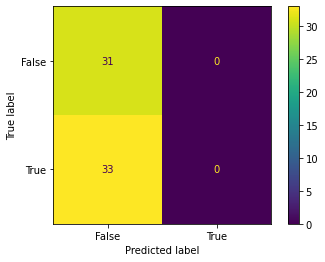

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

r = confusion_matrix(Y_test, y_pred)
r = np.flip(r)

cm_display = ConfusionMatrixDisplay(confusion_matrix = r, display_labels = [False, True])
cm_display.plot()
plt.show()